# A simple Movie Recommendation process based on plot descriptions

For this part of the project, we'll transform the movie plots/descriptions using the sentence encoder and see what movies are closes to a given movie. We would expect to see movies of the same/similar genre. Let's get to work and check out of that is the case.

In [1]:
#Importing the required modules.

import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
import cv2
import urllib.request
import requests

### STEP 1

In [3]:
new_df = pd.read_csv('clean_movie_data.csv')

In [4]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0    imdb_id               original_title  \
0           0  tt0114709                    Toy Story   
1           1  tt0113497                      Jumanji   
2           2  tt0113228             Grumpier Old Men   
3           3  tt0114885            Waiting to Exhale   
4           4  tt0113041  Father of the Bride Part II   

                     genres  \
0   Animation,Comedy,Family   
1  Adventure,Fantasy,Family   
2            Romance,Comedy   
3      Comedy,Drama,Romance   
4                    Comedy   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and stepped on, the wom...   
4  Just when George Banks has recovered from his ...   

                                        overview_new  
0  Led by Woody  Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on  mistreated and stepped on  the wom...  
4  Just when George Banks has recovered from his ...

In [5]:
new_df = new_df.drop('Unnamed: 0', axis =1)

In [6]:
new_df = new_df.reset_index(drop = True)

In [7]:
len(new_df)

20893

In [8]:
# Dropping NaN values

data = new_df.dropna()

In [9]:
len(data)

19843

Next, we'll make a unique list of all the genres contained in the data file.

In [10]:
genres_list = []

In [11]:
for j in data['genres']:     #Looping over the genres column of the dataframe.
    words = j.split(',')            #The different genres have been separated by a comma. Hence this string will be split by identifying the ',' character.
    for k in words:                 #Since the different list of words will be identified, the for loop will be used to iterate through all the different words in this list.
        if k not in genres_list:    #Only uniquely identified strings will be appended.
            genres_list.append(k)

In [12]:
genres_list

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Sci-Fi',
 'Mystery',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'Western',
 'TV',
 'Movie']

In [13]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and stepped on, the wom...   
4  Just when George Banks has recovered from his ...   

                                        overview_new  
0  Led by Woody  Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on  mistreated and stepped on  the wom...  
4  Just when George Banks has recovered from his ...

In [14]:
data = data.reset_index(drop = True)

In [15]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                            overview  \
0  Led by Woody, Andy's toys live happily in his ...   
1  When siblings Judy and Peter discover an encha...   
2  A family wedding reignites the ancient feud be...   
3  Cheated on, mistreated and stepped on, the wom...   
4  Just when George Banks has recovered from his ...   

                                        overview_new  
0  Led by Woody  Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on  mistreated and stepped on  the wom...  
4  Just when George Banks has recovered from his ...

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [16]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [18]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 230.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 490.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 750.00MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/3, Total size: 810.60MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.


In [17]:
all_descriptions = data['overview_new'].tolist()

### Why is the file being split?

The reason for this is that it wasn't possible to generate the sentence embeddings as a bulk file. Some runtime errors were observed. If one has to make an educated guess, it could be that the traditional Tesla K80 GPUs aren't compatible with the transformer encoder version of the sentence encoder. This is just a hunch but there could be other uderlying issues which will not be dicussed in detail.

In [18]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:]

In [19]:
final_set = [set_1, set_2]

In the next step,the sentence embeddings will be generated and the files will be stored as two numpy arrays.

In [22]:
tf.logging.set_verbosity(tf.logging.ERROR)
j = 0 # This variable will be used for naming convention of the files.
for i in final_set:
    j+=1 # Each time a sublist is read from full_set(our master list), this variable is incremented by 1
    with tf.device('/device:CPU:0'): # This module doesn't seem to be working with K80 GPUs. 
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i)) #Sentence embeddings are generated
            np.save('movie_set' + str(j) + '.npy', description_embeddings) #Embeddings are saved locally.    

In [20]:
#Loading the numpy arrays that contain the sentence embeddings

set_1 = np.load('movie_set1.npy')
set_2 = np.load('movie_set2.npy')
full_set = np.concatenate([set_1, set_2])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate movie plots/descriptions, the computed cosine similarity is 1. If the movie synopses are vastly different from one another, the similarity coefficient will be close to 0. 

In [21]:
cos_matrix = cosine_similarity(full_set)

In [22]:
cos_matrix.shape

(19843, 19843)

Next, we'll compute the cosine similarities of all the products in our dataset.

We get a square matrix of size 19843x19843.

For illustrative purposes, movie posters will be used to help identify movies that are closes in terms of descriptions. The images here serve to better visualize our results.

The Key below is the unique __[TMDB API](https://www.themoviedb.org/documentation/api)__ key granted to each registered user. Please refer to this __[detailed article](https://www.johannesbader.ch/2013/11/tutorial-download-posters-with-the-movie-database-api-in-python/)__ for retrieving information from the TMDB API.

In [64]:
KEY = '***'

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [61]:
def get_images(imdb_id):
    for num in range(1):
        IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' # The URL pattern for the movie posters. With the key and IMDB ID, the generated URL can be used to download the posters.
        r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdb_id)) # KEY is the API key and i[0] identifies the unique IMDB ID.
        api_response = r.json() # The generated response is converted to json.
    
        try:                     
            posters = api_response['posters'] # Contains information about the movie posters to be downloaded.
        except KeyError:
            continue
       # print('error for ' + imdb_id)
                  # 'continue' can only be used in a loop. This command moves on the next row if no vible information is found.
    
        base_url = 'http://image.tmdb.org/t/p/'  # The base url for the TMDB API
        max_size = 'w342'                        # Movie sizes are available in different sizes: w342, w500, and orignal. w342 images are smaller than w500 and 'original' images.
        try:           
            rel_path = posters[0]['file_path']   # Some movies have multiple posters. A few movies have up to 9 posters or so. What's even more bothersome is that some of them are duplicates. Hence, onlyone image per movie will be used.
        except IndexError:
            continue
        url = "{0}{1}{2}".format(base_url, max_size, rel_path) # If the movie does have a poster, this step generated the movie poster url
    #print(url)
    
        try:   
            resp = urllib.request.urlopen(url)                        # This step read the image from the url
            image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
            new_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except urllib.error.URLError as e:
            continue
            
        return new_img # Returns the image stored as a Numpy array.

Let's test this out!

In [66]:
poster = get_images('tt0114709')

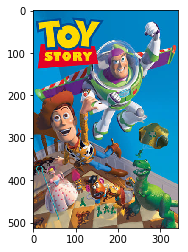

In [67]:
plt.imshow(poster)

The function defined in the next cell block is the crux of this part of the project. Given a movie ID, it retrieves the computed sentence embedding for that movie. Then, using the computed cosinesimilaritis matrix, the movies(12 of them) closest in description will be retrieved. Then using the IMDB ID of these movies, their posters will be downloaded and displayed.

In [27]:
def get_related_movies(imdbid, data = data):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    movie = data.loc[data.imdb_id == imdbid].index #Retrieves the index of the movie.
    index_list = [] 
    for k in movie:
        index_list.append(k)
    index_num = index_list[0]
    similar_prod_arr = cos_matrix[index_num].argsort()[::-1][:13] # Computes the 12 closes movie descriptions based on cosin similarity matrix.
    #print(similar_prod_arr)
    prod_img = get_images(imdbid) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,16))
    plt.subplot(5,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(prod_img) # Plotting the movie poster
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        img = get_images(data['imdb_id'].loc[i]) # Retrieves the images of all items related to the given movie
        plt.subplot(5,3,j) 
    # The try except method has ben used because some movies do not have valid poster URLs. For such movies, the function will 
    # continue downloading other movie posters and we will not encounter an error.
        try:
            plt.imshow(img) # Plots the images
            plt.xlabel('Related movie ID: ' + str(i))
            plt.xticks([])
            plt.yticks([])
            j+=1
        except:
            continue

In [68]:
data.loc[data.original_title.str.contains('Tangled')]

imdb_id      original_title                          genres  \
7348   tt0398286             Tangled                Animation,Family   
10833  tt2112281  Tangled Ever After  Animation,Comedy,Action,Family   
14174  tt0238137             Tangled          Drama,Mystery,Thriller   

                                                overview  \
7348   When the kingdom's most wanted-and most charmi...   
10833  The kingdom is in a festive mood as everyone g...   
14174  A young man is found bruised, beaten and stumb...   

                                            overview_new  
7348   When the kingdom's most wanted and most charmi...  
10833  The kingdom is in a festive mood as everyone g...  
14174  A young man is found bruised  beaten and stumb...

/home/streetraider92/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


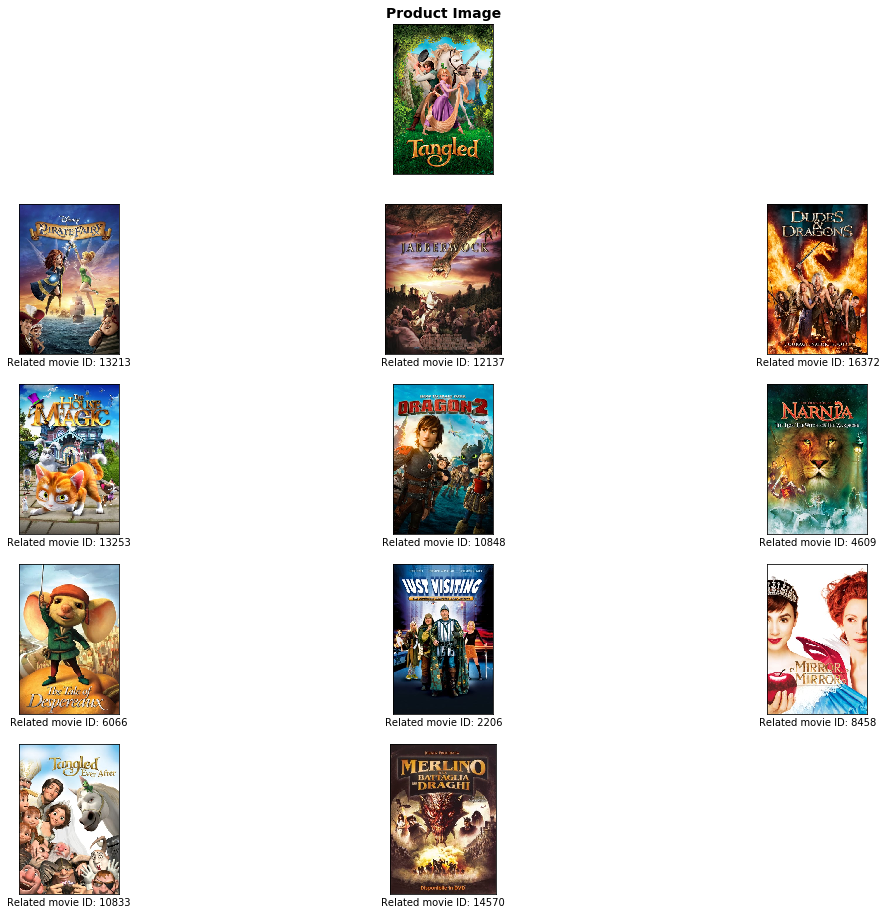

In [69]:
get_related_movies('tt0398286')

Given the movie plot of Tangled, the closes movies in terms of description were other children's movies!

In [46]:
data.loc[data.imdb_id == 'tt2345759']

imdb_id original_title                     genres  \
29350  tt2345759      The Mummy  Thriller,Action,Adventure   

                                                overview  \
29350  Though safely entombed in a crypt deep beneath...   

                                            overview_new  
29350  Though safely entombed in a crypt deep beneath...

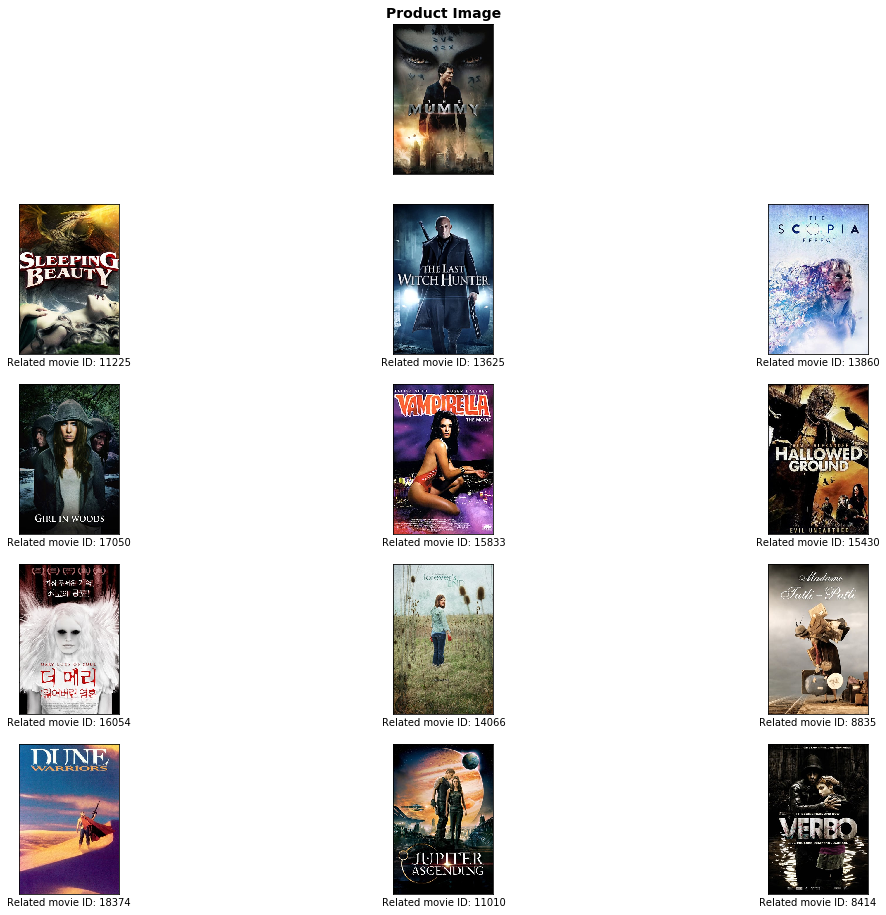

In [33]:
get_related_movies('tt2345759')

In [47]:
data['genres'].loc[[11225, 13625, 13860, 17050, 15430, 18374, 11010]]

11225                  Fantasy,Adventure
13625           Fantasy,Action,Adventure
13860             Thriller,Horror,Sci-Fi
17050              Drama,Horror,Thriller
15430                             Horror
18374                            Fantasy
11010    Sci-Fi,Fantasy,Action,Adventure
Name: genres, dtype: object

For "The Mummy", which is a horror/Sci-fi/thriller flick, the closest movies were also horror, sci-fi and thriller.

In [47]:
data.loc[data.imdb_id == 'tt0429493']

imdb_id original_title                                  genres  \
12094  tt0429493     The A-Team  Thriller,Action,Adventure,Comedy,Crime   

                                                overview  \
12094  A group of Iraq War veterans goes on the run f...   

                                            overview_new  
12094  A group of Iraq War veterans goes on the run f...

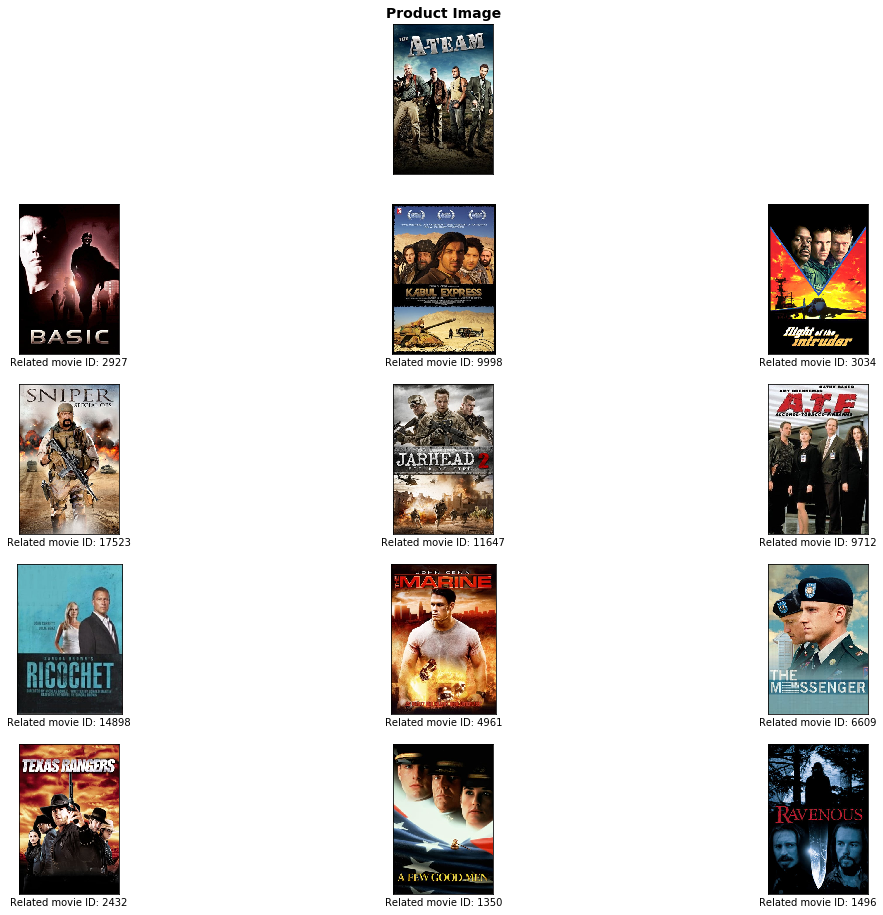

In [34]:
get_related_movies('tt0429493')

In [48]:
data['genres'].loc[[2927,9998, 3034, 11647, 9712, 2432, 1496]]

2927     Action,Drama,Mystery,Thriller,Crime
9998            Action,Comedy,Drama,Thriller
3034         Action,Adventure,Drama,Thriller
11647                             War,Action
9712                      Action,Crime,Drama
2432                          Action,Western
1496          Comedy,Horror,Thriller,Western
Name: genres, dtype: object

For the "A-TEAM", a comedy/action/adventure flick, the closes movies were other action movies.

In [50]:
data.loc[data.original_title.str.contains('Inception')]

imdb_id original_title                                    genres  \
12194  tt1375666      Inception  Action,Thriller,Sci-Fi,Mystery,Adventure   

                                                overview  \
12194  Cobb, a skilled thief who commits corporate es...   

                                            overview_new  
12194  Cobb  a skilled thief who commits corporate es...

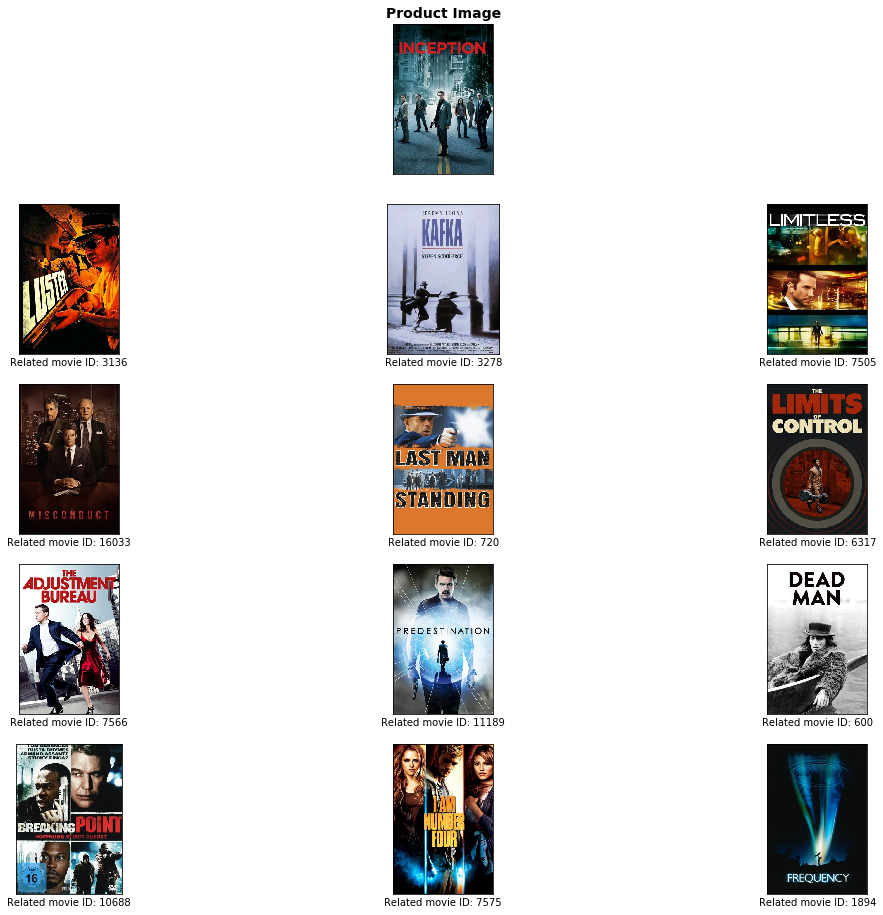

In [35]:
get_related_movies('tt1375666')

In [49]:
data['genres'].loc[[3136,3278, 7505, 16033, 720, 6317, 7566, 600, 1894]]

3136                            Drama
3278             Comedy,Drama,Mystery
7505          Thriller,Mystery,Sci-Fi
16033                  Drama,Thriller
720       Action,Crime,Drama,Thriller
6317     Crime,Drama,Thriller,Mystery
7566          Sci-Fi,Thriller,Romance
600             Drama,Fantasy,Western
1894      Crime,Drama,Sci-Fi,Thriller
Name: genres, dtype: object

For "Inception", we get other Mystery/Thriller/Sci-fi movies!

In [53]:
data.loc[data.original_title.str.contains('Step Brothers')]

imdb_id original_title  genres  \
10356  tt0838283  Step Brothers  Comedy   

                                                overview  \
10356  Brennan Huff and Dale Doback might be grown me...   

                                            overview_new  
10356  Brennan Huff and Dale Doback might be grown me...

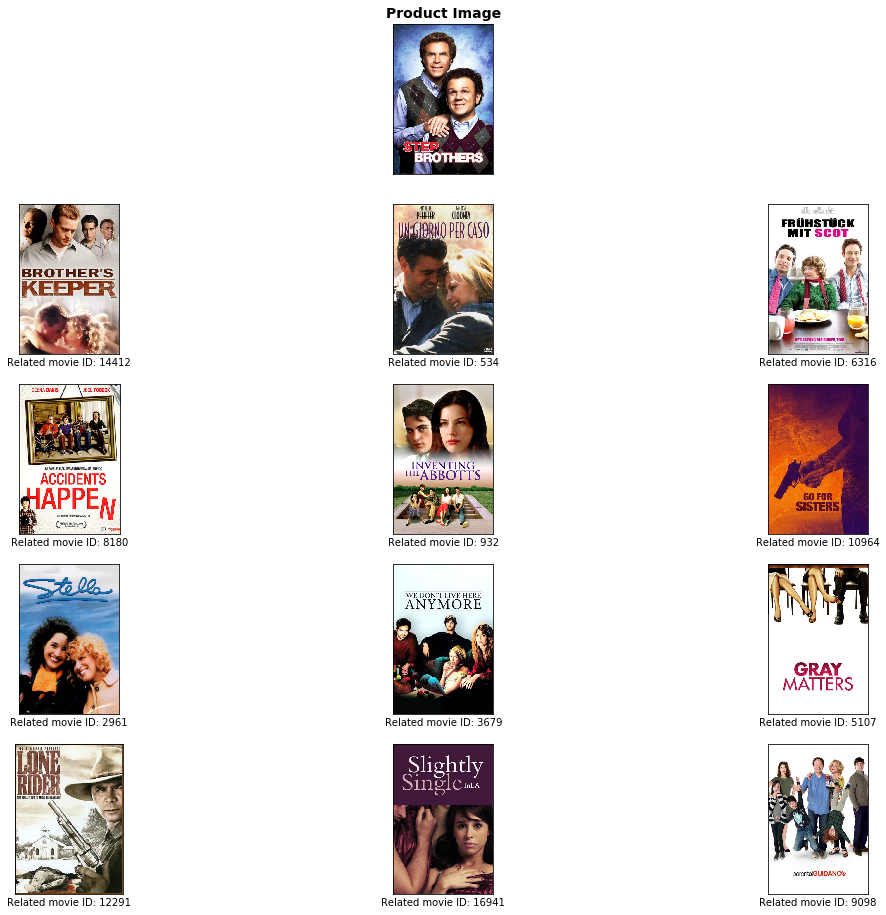

In [36]:
get_related_movies('tt0838283')

In [52]:
data['genres'].loc[[14412, 534, 6316, 8180, 10964, 5107, 12291, 16941]]

14412                      Drama
534               Comedy,Romance
6316                Comedy,Drama
8180                Comedy,Drama
10964                Crime,Drama
5107              Comedy,Romance
12291    TV,Movie,Action,Western
16941             Comedy,Romance
Name: genres, dtype: object

For Step brothers, a comedy flick, we mostly get other comedy and rom/com flicks as closes movies!

In [56]:
data.loc[data.original_title.str.contains('Guardians of')]

imdb_id                  original_title  \
17771  tt2015381         Guardians of the Galaxy   
19777  tt3896198  Guardians of the Galaxy Vol. 2   

                               genres  \
17771         Action,Sci-Fi,Adventure   
19777  Action,Adventure,Comedy,Sci-Fi   

                                                overview  \
17771  Light years from Earth, 26 years after being a...   
19777  The Guardians must fight to keep their newfoun...   

                                            overview_new  
17771  Light years from Earth  26 years after being a...  
19777  The Guardians must fight to keep their newfoun...

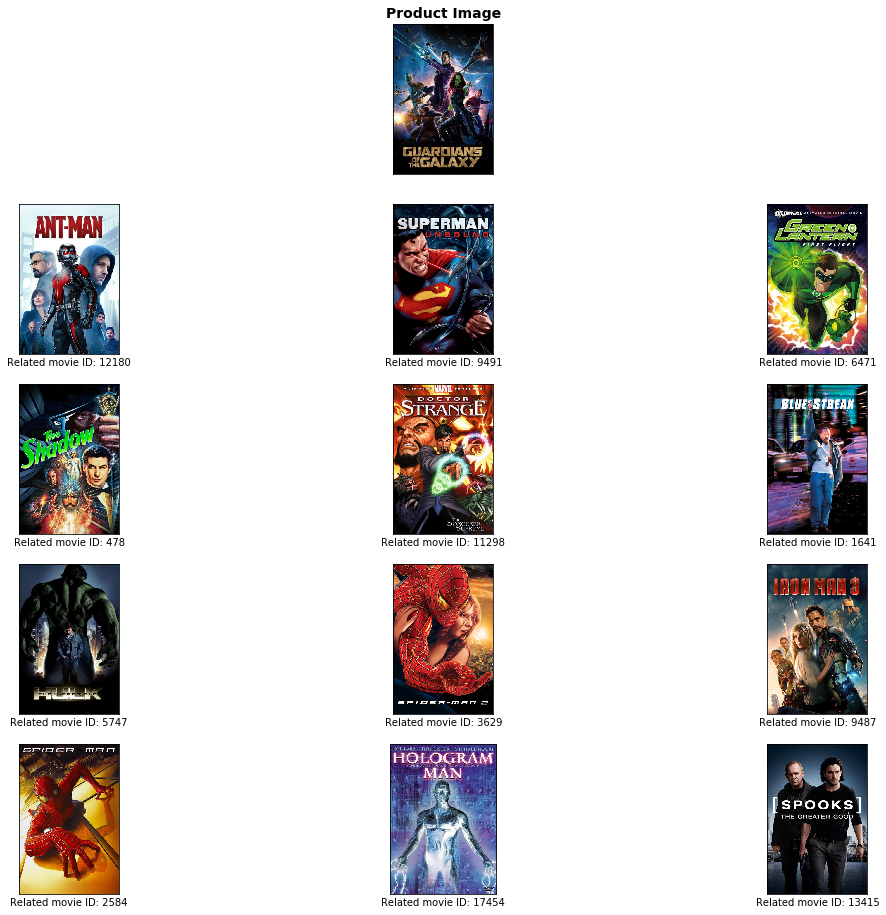

In [37]:
get_related_movies('tt2015381')

Given the plot of Guardians of the Galaxy, we get other Superhero flicks. A very interesting result, indeed.

Similarly, let's observe other results.

In [110]:
data.loc[data.original_title.str.contains('The Hangover')]

imdb_id         original_title  genres  \
11020  tt1119646           The Hangover  Comedy   
13259  tt1411697   The Hangover Part II  Comedy   
15830  tt1951261  The Hangover Part III  Comedy   

                                                overview  \
11020  When three friends finally come to after a rau...   
13259  The Hangover crew heads to Thailand for Stu's ...   
15830  This time, there's no wedding. No bachelor par...   

                                            overview_new  
11020  When three friends finally come to after a rau...  
13259  The Hangover crew heads to Thailand for Stu's ...  
15830  This time  there's no wedding. No bachelor par...

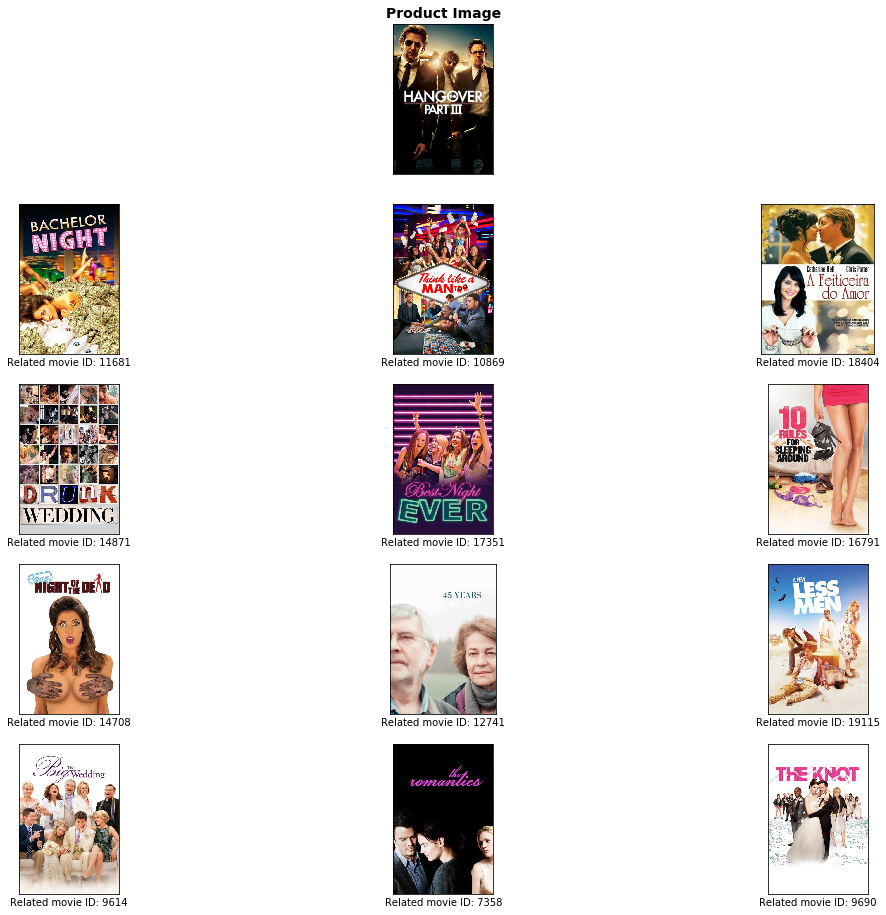

In [38]:
get_related_movies('tt1951261')

In [70]:
data.loc[data.imdb_id == 'tt1454468']

imdb_id original_title                 genres  \
16297  tt1454468        Gravity  Sci-Fi,Thriller,Drama   

                                                overview  \
16297  Dr. Ryan Stone, a brilliant medical engineer o...   

                                            overview_new  
16297  Dr. Ryan Stone  a brilliant medical engineer o...

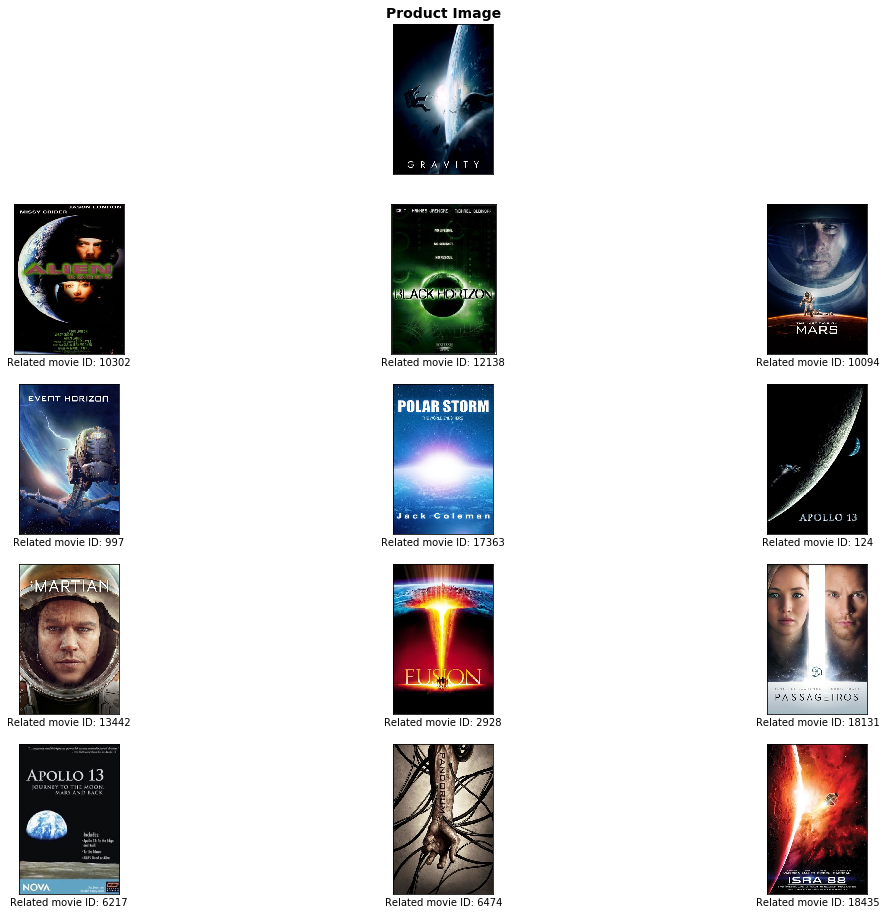

In [39]:
get_related_movies('tt1454468')

In [51]:
data.loc[data.original_title.str.contains('Silence of')]

imdb_id            original_title                genres  \
528  tt0102926  The Silence of the Lambs  Crime,Drama,Thriller   

                                              overview  \
528  FBI trainee, Clarice Starling ventures into a ...   

                                          overview_new  
528  FBI trainee  Clarice Starling ventures into a ...

/home/streetraider92/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


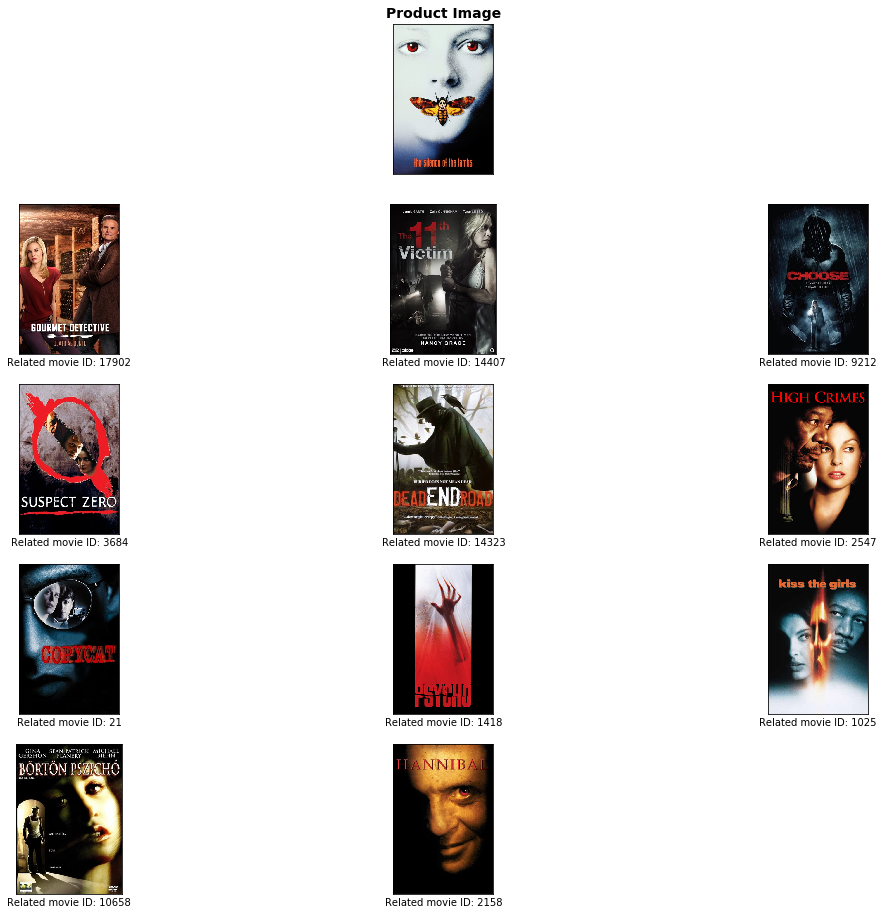

In [52]:
get_related_movies('tt0102926')

In [54]:
data.loc[data.original_title.str.contains('The Time Machine')]

imdb_id    original_title                   genres  \
2517  tt0268695  The Time Machine  Sci-Fi,Adventure,Action   

                                               overview  \
2517  Hoping to alter the events of the past, a 19th...   

                                           overview_new  
2517  Hoping to alter the events of the past  a 19th...

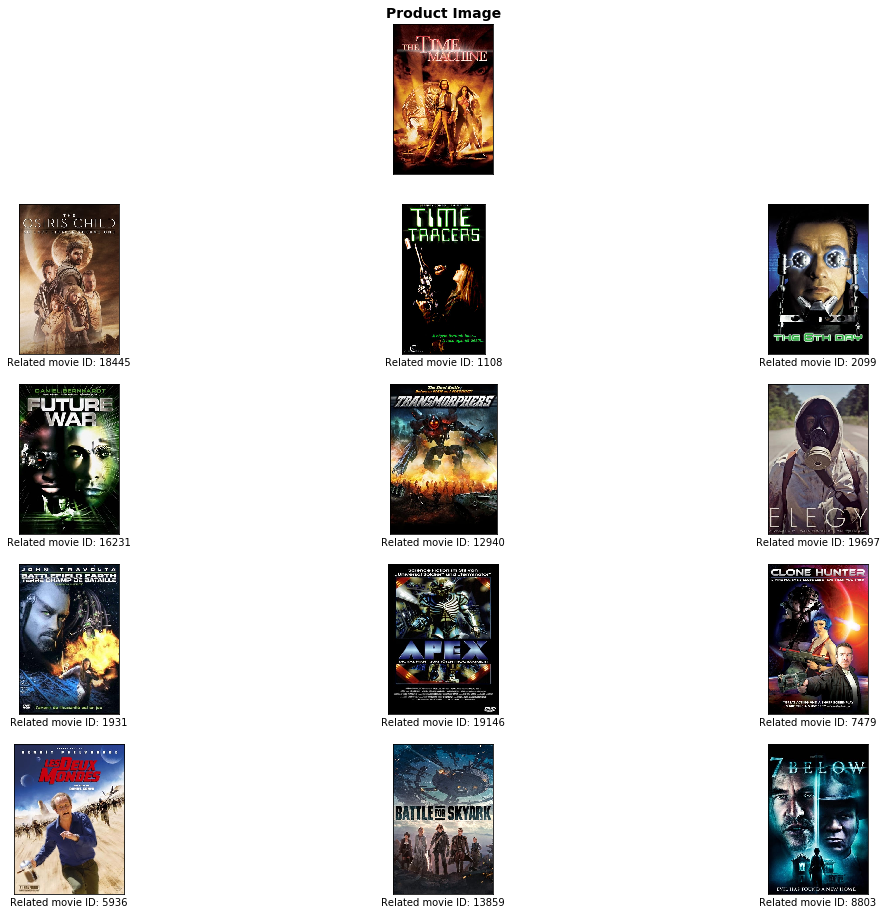

In [50]:
get_related_movies('tt0268695')

In [120]:
data.loc[data.original_title.str.contains('Shanghai Noon')]

imdb_id original_title                           genres  \
3073  tt0184894  Shanghai Noon  Adventure,Action,Comedy,Western   

                                               overview  \
3073  Chon Wang, a clumsy imperial guard trails Prin...   

                                           overview_new  
3073  Chon Wang  a clumsy imperial guard trails Prin...

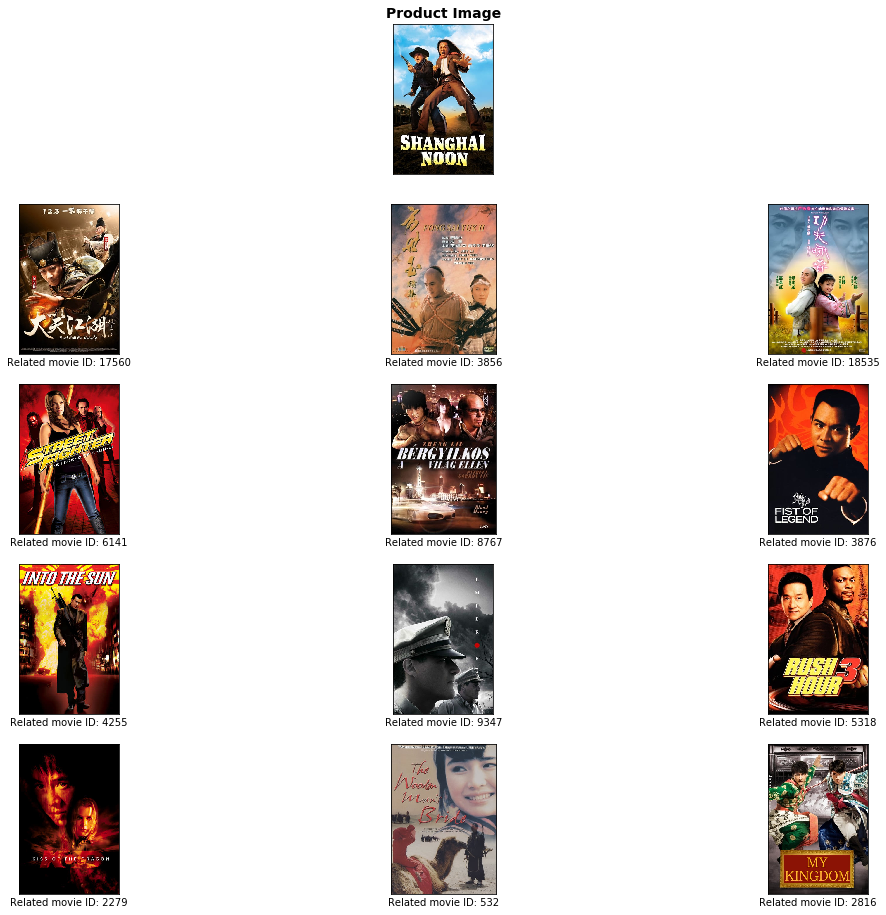

In [43]:
get_related_movies('tt0184894')

In [47]:
data.loc[data.original_title.str.contains('Beauty and')]

imdb_id                                 original_title  \
529    tt0101414                           Beauty and the Beast   
8577   tt0118692  Beauty and the Beast: The Enchanted Christmas   
10682  tt1410295                           Beauty and the Beast   
18458  tt2771200                           Beauty and the Beast   

                                       genres  \
529    Romance,Family,Animation,Fantasy,Music   
8577                         Animation,Family   
10682                                 Fantasy   
18458                  Family,Fantasy,Romance   

                                                overview  \
529    Follow the adventures of Belle, a bright young...   
8577   Belle prepares the castle for Christmas agains...   
10682  A twist on the morality tale of forbidden love...   
18458  A live-action adaptation of Disney's version o...   

                                            overview_new  
529    Follow the adventures of Belle  a bright young...  
8577   Belle prepares the castle for Christmas agains...  
10682  A twist on the morality tale of forbidden love...  
18458  A live action adaptation of Disney's version o...

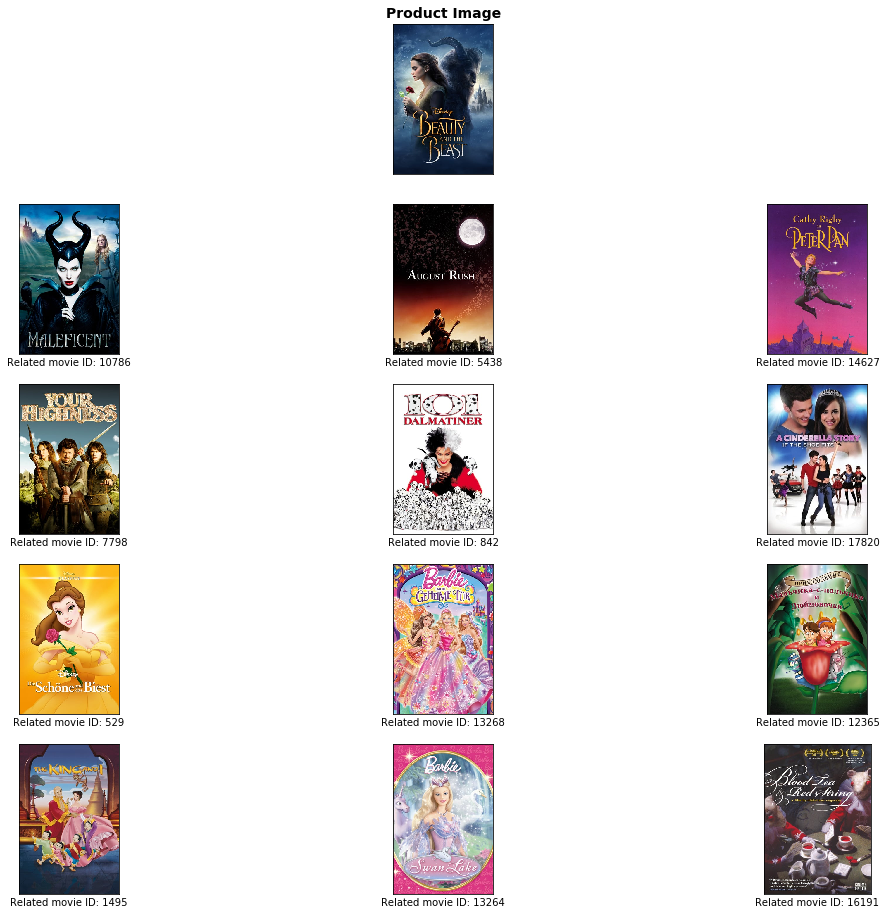

In [48]:
get_related_movies('tt2771200')

In [92]:
data.loc[15295]

imdb_id                                                   tt2452042
original_title                                    The Peanuts Movie
genres                                                    Animation
overview          Snoopy embarks upon his greatest mission as he...
overview_new      Snoopy embarks upon his greatest mission as he...
Name: 15295, dtype: object

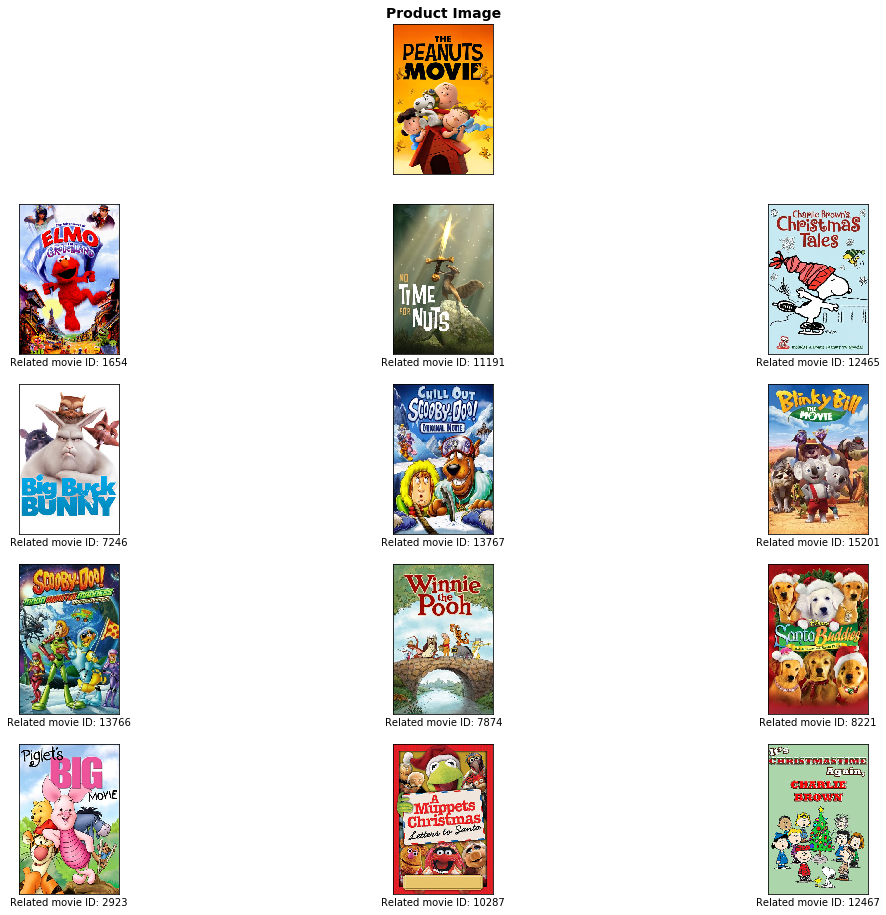

In [93]:
get_related_movies('tt2452042')

In [72]:
data.loc[10746]

imdb_id                                                   tt1877832
original_title                           X-Men: Days of Future Past
genres                              Action,Adventure,Fantasy,Sci-Fi
overview          The ultimate X-Men ensemble fights a war for t...
overview_new      The ultimate X Men ensemble fights a war for t...
Name: 10746, dtype: object

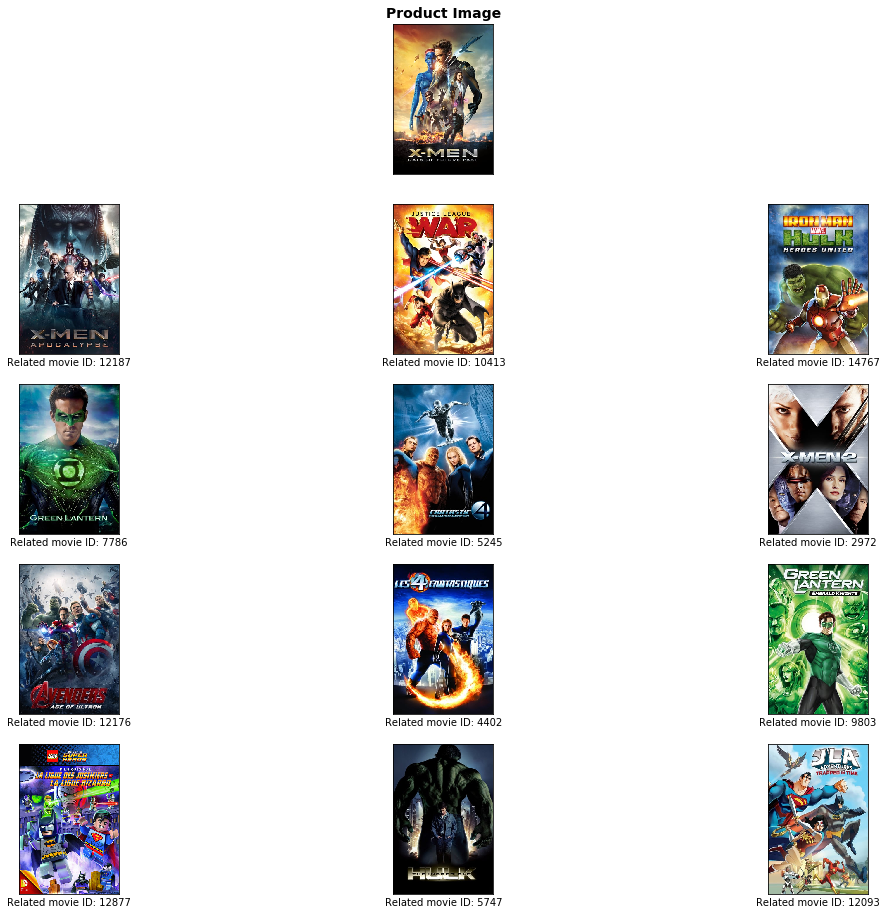

In [69]:
get_related_movies('tt1877832')